In [7]:
from sklearn.linear_model import LinearRegression, Ridge

ALGORITHM = 'Linear Regression (Ridge)'
ALGORITHM_DETAIL = 'random search'
VERSION = '05'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', Ridge())
])

In [9]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

confirm_colab = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB:
    from functions_20221019 import set_csv_directory, get_combined_dataset, get_columns
    from functions_20221019 import add_supplements, tidy_dataset, feature_engineer, preprocess

    set_csv_directory('final_split')

debug_mode = False

In [10]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [11]:
filename = f'df_listings_v{VERSION}.csv'
remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
df_pathname_raw = f'../../data/source/{filename}'
df_pathname_tidy = f'../../data/final/{filename}'


def get_source_dataframe(rows=cutdown_rows, folder_prefix='../'):
    retrieval_type = None

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    features = df[df.columns[2:]].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.9,
                                                                random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index



In [12]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../data/final/df_listings_v05.csv
(46877, 9)


In [13]:
df

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
...,...,...,...,...,...,...,...,...,...
126179018,575000.0,2.0,1.0,0.682879,51.370651,-0.238346,0.129069,0.133926,FREEHOLD
126179672,600000.0,3.0,2.0,0.545665,51.357170,-0.074740,0.142550,0.029680,LEASEHOLD
126180107,419999.0,2.0,1.0,0.191407,51.531415,-0.052964,0.031695,0.051456,LEASEHOLD
126180704,475000.0,2.0,1.0,0.308609,51.543141,0.011498,0.043421,0.115918,LEASEHOLD


In [14]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [15]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46877 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46877 non-null  float64
 1   bedrooms             46877 non-null  float64
 2   bathrooms            46877 non-null  float64
 3   nearestStation       46877 non-null  float64
 4   location.latitude    46877 non-null  float64
 5   location.longitude   46877 non-null  float64
 6   latitude_deviation   46877 non-null  float64
 7   longitude_deviation  46877 non-null  float64
 8   tenure.tenureType    44133 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,46877.000000,46877.000000,46877.000000,46877.000000,46877.000000,46877.000000,46877.000000,46877.000000
mean,425062.235531,1.992448,1.182115,0.440245,51.497056,-0.113270,0.064316,0.124201
std,107229.476820,0.828823,0.409907,0.350941,0.077085,0.156486,0.042575,0.095604
min,100000.000000,1.000000,1.000000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.000000,0.227201,51.438866,-0.210803,0.028875,0.043560
50%,425000.000000,2.000000,1.000000,0.367989,51.499980,-0.102230,0.058595,0.098984
75%,515000.000000,3.000000,1.000000,0.559762,51.556187,-0.010345,0.094355,0.192683
max,600000.000000,7.000000,5.000000,16.168861,51.683185,0.279726,0.201403,0.393895


In [16]:
old_length = len(df)

df = preprocess(df, version=int(VERSION))

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46877 ==> 46877


,count,mean,std,min,25%,50%,75%,max
Price,46877.0,425062.235531,107229.476820,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46877.0,1.992448,0.828823,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46877.0,1.182115,0.409907,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46877.0,0.440245,0.350941,0.000000,0.227201,0.367989,0.559762,16.168861
location.latitude,46877.0,51.497056,0.077085,51.298317,51.438866,51.499980,51.556187,51.683185
location.longitude,46877.0,-0.113270,0.156486,-0.498315,-0.210803,-0.102230,-0.010345,0.279726
latitude_deviation,46877.0,0.064316,0.042575,0.000000,0.028875,0.058595,0.094355,0.201403
longitude_deviation,46877.0,0.124201,0.095604,0.000000,0.043560,0.098984,0.192683,0.393895


In [17]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [18]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46877 ==> 44133


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44133.000000,44133.000000,44133.000000,44133.000000,44133.000000,44133.000000,44133.000000,44133.000000
mean,425217.021141,1.990959,1.181384,0.440008,51.496719,-0.113106,0.064543,0.123698
std,107205.633151,0.827606,0.408961,0.350783,0.077267,0.155860,0.042584,0.095217
min,100000.000000,1.000000,1.000000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.000000,0.227574,51.438306,-0.210640,0.029023,0.043552
50%,425000.000000,2.000000,1.000000,0.368397,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.000000,0.559534,51.556384,-0.010855,0.094620,0.191725
max,600000.000000,7.000000,5.000000,16.168861,51.683185,0.279726,0.201403,0.393895


In [19]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(39719, 11) (4414, 11) (39719, 1) (4414, 1) (39719, 1) (4414, 1) (39719, 1) (4414, 1)


In [20]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [21]:
from time import time

#pipe.fit(X_train, y_train)

model = LinearRegression()
#model.fit(X_train, y_train)
model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [22]:

from sklearn.pipeline import Pipeline

# Best Score:  0.30582573121661794
# Best Score:  {'alpha': 10, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'selection': 'cyclic', 'tol': 0.001, 'warm_start': True}
# Best Score:  Lasso(alpha=10, tol=0.001, warm_start=True)
# Best Score:  138

# find optimal alpha with grid search
alpha = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
#alpha = [1, 10, 100]
fit_intercept = [True, False]
max_iter = [100, 1000, 10000]
positive = [True, False]
solver = ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']
tol = [0.00001, 0.0001, 0.001, 0.01]
warm_start = [True, False]
# ['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'precompute', 'random_state', 'selection', 'tol', 'warm_start'].

options__n_neighbours = [3, 5, 7, 9, 15, 31]
options__leafsize = [2, 3, 4, 57, 9, 13, 21]

param_grid = dict(model__alpha=alpha, model__fit_intercept=fit_intercept, model__max_iter=max_iter,
                  model__positive=positive,
                  model__tol=tol, model__solver=solver)
#param_grid = dict(estimator__n_neighbors=options__n_neighbours, estimator__leaf_size= options__leafsize)

#param_grid = {'model__n_neighbors': options__n_neighbours,'model__leaf_size': options__leafsize},
#param_grid = {'n_neighbors': options__n_neighbours,                   'leaf_size': options__leafsize},
cv = 2
n_jobs = 1
verbose = 1
refit = True

#grid = RandomizedSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)

gs = RandomizedSearchCV(pipe, param_grid, cv=cv, n_jobs=n_jobs,
                        verbose=verbose, scoring=CROSS_VALIDATION_SCORING, refit=refit,
                        return_train_score=True),
gs

grid_result = gs[0].fit(X_train, y_train)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
8 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/guava/PycharmProjects/capstone_strea

In [23]:
pipe = grid_result.best_estimator_
timings = []

t0 = time()
pipe.fit(X_train, y_train)
timings.append(time() - t0)

print(timings)
average_time = sum(timings) / len(timings)
print(average_time)

[0.2222280502319336]
0.2222280502319336


In [24]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}')


print_results(grid_result)
print('Best Index: ', grid_result.best_index_)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print('Best Model: ', grid_result.)
#print('Best Params: ', grid_result.best_params_)[out]
### Best Score:  0.4883436188936269
### Best Params:  {'alpha': 0.01}


BEST PARAMS: {'model__tol': 0.001, 'model__solver': 'sag', 'model__positive': False, 'model__max_iter': 10000, 'model__fit_intercept': True, 'model__alpha': 0.1}
nan (+/-nan) for {'model__tol': 1e-05, 'model__solver': 'lbfgs', 'model__positive': False, 'model__max_iter': 10000, 'model__fit_intercept': True, 'model__alpha': 0.001}
nan (+/-nan) for {'model__tol': 0.001, 'model__solver': 'sag', 'model__positive': True, 'model__max_iter': 10000, 'model__fit_intercept': True, 'model__alpha': 100}
-15.221 (+/-0.137) for {'model__tol': 1e-05, 'model__solver': 'saga', 'model__positive': False, 'model__max_iter': 100, 'model__fit_intercept': False, 'model__alpha': 1}
0.445 (+/-0.01) for {'model__tol': 0.001, 'model__solver': 'sag', 'model__positive': False, 'model__max_iter': 10000, 'model__fit_intercept': True, 'model__alpha': 0.1}
-15.388 (+/-0.122) for {'model__tol': 1e-05, 'model__solver': 'lbfgs', 'model__positive': True, 'model__max_iter': 1000, 'model__fit_intercept': False, 'model__alph

In [25]:
y_pred = pipe.predict(X_test)

In [26]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Linear Regression (Ridge)----------
R square Accuracy 0.44347189301323553
Mean Absolute Error Accuracy 63769.72935094095
Mean Squared Error Accuracy 6191347503.226655
Root Mean Squared Error 78685.11614801528


In [27]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [28]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
122562932.0,550000.0,520119.870922,29880.129078,5.432751,5.744854
117089147.0,375000.0,398537.332521,23537.332521,6.276622,5.905929
123446663.0,475000.0,399799.609173,75200.390827,15.831661,18.809521
124867340.0,450000.0,366177.398735,83822.601265,18.627245,22.891255
121165313.0,325000.0,390000.590329,65000.590329,20.000182,16.666793
...,...,...,...,...,...
126115436.0,425000.0,399905.932101,25094.067899,5.904487,6.274993
123739259.0,235000.0,371241.243284,136241.243284,57.974997,36.698844
68620869.0,475000.0,535322.606964,60322.606964,12.699496,11.268459


In [29]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType


In [30]:
score = pipe.score(X_test, y_test)
score

0.44347189301323553

In [31]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.44347189301323553

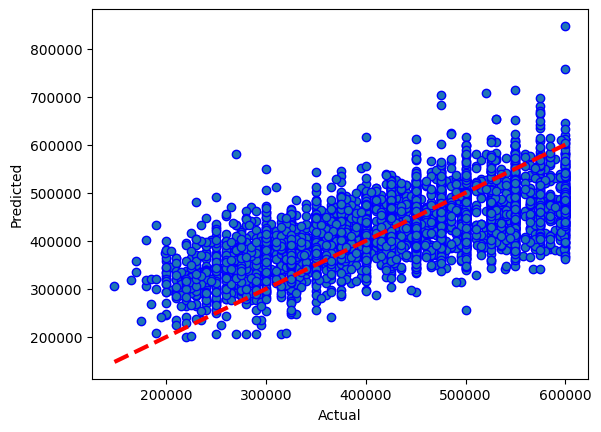

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [33]:
if False:
    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            #return pd.Series({**params, **d})
            return pd.Series({**params, **d, **{'params_full': str(params)}})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]


    import seaborn as sns

    score_summary = score_summary(self=gs, sort_by='max_score')

In [34]:

if False:
    #sns.set(rc={"figure.figsize": (10, 10)})
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    #total_graphs = len(score_summary)
    # max_horizontal = 4
    # index2 = 0
    # resultant_rows = math.ceil(total_graphs / max_horizontal)
    # #subplots_adjust()
    #
    # #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    best_estimator = score_summary.iloc[0]
    worst_estimator = score_summary.iloc[-1]

    name_best = best_estimator["estimator"]
    params_str = best_estimator["params_full"]
    params_best = ast.literal_eval(params_str)

    name_worst = worst_estimator["estimator"]
    params_str = worst_estimator["params_full"]
    params_worst = ast.literal_eval(params_str)

    KNeighborsRegressor().set_params()

    best_pipe = make_pipe(name_best)
    worst_pipe = make_pipe(name_worst)

    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test, y=best_pipe.set_params(**params_best).fit(X_train, y_train).predict(X_test), ax=axes[0],
                    s=100).set(
        title=f'"BEST" model: {name_best} \n{params_best}')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test, y=worst_pipe.set_params(**params_worst).fit(X_train, y_train).predict(X_test), ax=axes[1],
                    s=100).set(
        title=f'"WORST" model: {name_worst} \n{params_worst}')

    sns.scatterplot(x=y_test, y=worst_pipe.set_params(**params_worst).fit(X_train, y_train).predict(X_test), ax=axes[2],
                    s=100, color='orange')
    sns.scatterplot(x=y_test, y=best_pipe.set_params(**params_best).fit(X_train, y_train).predict(X_test), ax=axes[2],
                    s=100, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')

    fig.tight_layout()
    plt.show()

if False:
    max_horizontal = 3

    #sns.set()
    #sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
    sns.set(rc={"figure.figsize": (20, 20)})
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    total_graphs = len(score_summary)
    index2 = 0
    resultant_rows = math.ceil(total_graphs / max_horizontal)
    #subplots_adjust()

    #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
    fig, axes = plt.subplots(nrows=2, ncols=max_horizontal, figsize=(15, 10))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    for (key, next_estimator), index in zip(score_summary.iterrows(), range(total_graphs)):
        if index % (max_horizontal * 2) == 0 and index != 0:
            index2 = 0
            fig.tight_layout()
            plt.show()
            #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
            fig, axes = plt.subplots(nrows=2, ncols=max_horizontal, figsize=(15, 10))

        name_next = next_estimator["estimator"]
        params_str = next_estimator["params_full"]
        params_next = ast.literal_eval(params_str)
        #print("next", params_next)

        if 'noscale' in name_next:
            pipe = Pipeline(steps=[
                ('preprocessor', features_noscale_preprocessor),  # preprocess features
                ('estimator', models_and_params[name_next]["model"]),
            ])  # start the training
        else:
            pipe = Pipeline(steps=[
                ('preprocessor', features_preprocessor),
                ('estimator', models_and_params[name_next]["model"]),  # preprocess features
            ])  # start the training

        # 0 ==> 0,0
        # 1 ==> 0,1
        # 2 ==> 1,0
        x_coor = index2 // max_horizontal
        y_coor = index2 % max_horizontal

        coordinates = axes[x_coor][y_coor]
        #sns.lineplot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], hue='red', lw=3)
        sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=coordinates, color='red')
        sns.scatterplot(x=y_test, y=pipe.set_params(**params_next).fit(X_train, y_train).predict(X_test),
                        ax=coordinates, s=100).set(
            title=f'({index}) {"BEST" if index == 0 else "next"} model: {name_next} \n{params_next}')
        #if index == 11: break
        index2 += 1

    fig.tight_layout()
    plt.show()

In [35]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    'params': grid_result.best_params_
}
import json


def get_results():
    results_filename = '../../results/results.json'

    with open(results_filename) as f:
        raw_audit = f.read()
    results_json = json.loads(raw_audit)
    return results_json


def update_results(saved_results_json, new_results):
    key = f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()
    try:
        first_run_date = str(datetime.now())
        first_run_date = saved_results_json[key]['date']
        first_run_date = saved_results_json[key]['first run']
    except:
        pass

    try:
        max_score = -1000
        max_params = 'NOT APPLICABLE'
        max_score = saved_results_json[key]['Score']
        max_params = saved_results_json[key]['params']
        max_score = saved_results_json[key]['max score']
        max_params = saved_results_json[key]['max params']
    except:
        pass

    results['first run'] = first_run_date
    if key not in saved_results_json:
        new_results['max params'] = new_results['params']
        new_results['max score'] = new_results['Score']
        new_results['suboptimal'] = 'pending'
    elif max_score > saved_results_json[key]['Score']:
        new_results['suboptimal'] = 'suboptimal'
    elif max_score == saved_results_json[key]['Score']:
        if saved_results_json[key]['params'] != new_results['params']:
            new_results['max params'] = 'MULTIPLE PARAM OPTIONS'
        else:
            new_results['max params'] = saved_results_json[key]['params']
            new_results['max score'] = saved_results_json[key]['Score']
            new_results['suboptimal'] = 'pending'
    else:
        new_results['max params'] = saved_results_json[key]['params']
        new_results['max score'] = saved_results_json[key]['Score']
        new_results['suboptimal'] = 'pending'

    saved_results_json[key] = new_results

    results_filename = '../../results/results.json'
    with open(results_filename, 'w') as file:
        file.write(json.dumps(saved_results_json, indent=4, sort_keys=True))


if not IN_COLAB:
    results_json = get_results()
    update_results(results_json, results)

results

{'Score': 0.44347189301323553,
 'R square Accuracy': 0.44347189301323553,
 'Mean Absolute Error Accuracy': 63769.72935094095,
 'Mean Squared Error Accuracy': 6191347503.226655,
 'Root Mean Squared Error': 78685.11614801528,
 'Training Time': 0.2222280502319336,
 'random_state': 101,
 'date': '2022-10-19 00:13:33.769898',
 'params': {'model__tol': 0.001,
  'model__solver': 'sag',
  'model__positive': False,
  'model__max_iter': 10000,
  'model__fit_intercept': True,
  'model__alpha': 0.1},
 'first run': '2022-10-19 00:13:33.773722',
 'max params': {'model__tol': 0.001,
  'model__solver': 'sag',
  'model__positive': False,
  'model__max_iter': 10000,
  'model__fit_intercept': True,
  'model__alpha': 0.1},
 'max score': 0.44347189301323553,
 'suboptimal': 'pending'}